In [463]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import linregress as lin
from scipy.optimize import curve_fit
from scipy.signal import correlate
from datetime import datetime, timedelta
import re
from scipy.stats import pearsonr

from netCDF4 import Dataset

In [464]:
N = np.size(glob.glob("./dataGt/JPL_mscn*.csv", recursive=True))
M = np.shape(np.genfromtxt('JPL_mscn017.csv', delimiter=',', skip_header=15))[0]
t_30days = 30 * 24 * 3600.0

In [465]:
seasontype = 'summer'
outputtype = 'diff'

In [466]:
file_n = sorted(glob.glob("./dataGt/JPL_mscn*.csv", recursive=True))
file_ids = np.zeros(len(file_n), dtype=np.int)
area_mscn = np.ones(len(file_n))

data = np.empty((N, M, 2))
for i, fn in enumerate(file_n):
    file = np.genfromtxt(fn, delimiter=',', skip_header=15)
    #print(file.shape,i)
    area_mscn[i] = np.genfromtxt(fn, delimiter=',', skip_header=6, skip_footer=170)[1]
    data[i] = file
    file_ids[i] = int(re.search("JPL_mscn(.+?)csv", fn).group(1)[:-1])

In [467]:
#data[0,:,1] * 1e-2 * area_mscn[0] * 1e6 * 1000 * 1e-12

In [468]:
# Detrend
trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, data[i,:,0], data[i,:,1])
    trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
ddata = np.empty((N, M))
for i in range(N):
    ddata[i] = detrend(data[i,:,1], data[i,:,0], trends[i])
    
def resample_mascons(mascon_time, mascon_data, dt):
    """Resample mascon data on a given time scale to a linear time scale.
    
    Keyword arguments:
    mascon_time -- the mascon time scale in seconds
    mascon_data -- the mascon data associated with mascon_time
    dt -- the fixed sampling between min(mascon_time) and max(mascon_time) to use
    """
    
    t_min = np.min(mascon_time)
    t_max = np.max(mascon_time)
    t_range = np.arange(t_min, t_max, dt)
    ndata = np.empty((mascon_data.shape[0], t_range.size))
    for mi in range(ndata.shape[0]):
        ndata[mi,:] = np.interp(t_range, mascon_time, mascon_data[mi,:])
    return t_range, ndata
    
# Three point smoother with Weighted average
ddata_n = 2.0 * ddata.T + np.vstack((ddata.T[0], ddata.T[:-1])) + np.vstack((ddata.T[1:], ddata.T[-1]))
ddata = ddata_n.T / 4.0

# Resample mascons with sample width
# dt = 30 days 
# First convert time stamps to seconds
grace_t = data[0,:,0] * 86400 
grace_t, ddata = resample_mascons(grace_t, ddata, t_30days)
grace_t_copy = grace_t

ddata_copy = ddata

#tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])

In [469]:
data_num = -1

#xlist = data[data_num-1][:,0] * 86400.0
#ylist = data[data_num-1][:,1]
xlist, ylist = resample_mascons(data[0,:,0] * 86400, data[:,:,1], t_30days)
xlist = xlist / (86400.0 * 365.25)
ylist = ylist[data_num-1]

trend = lin(xlist,ylist)

In [470]:
#xlist = 2002 + data[data_num-1][:,0]/365.25
#tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
#ylist = data[data_num-1][:,1]

xlist, ylist = resample_mascons(data[0,:,0] * 86400,  data[:,:,1], t_30days)
xlist = xlist / (86400. * 365.25)

detrended = detrend(ylist[data_num-1], xlist, trends[data_num-1])

In [471]:
#xlist = 2002 + data[0][:,0]/365.25
#ylist = np.sum(data, axis = 0)[:,1]

xlist, ylist = resample_mascons(data[0,:,0] * 86400.0, data[:,:,1], t_30days)
xlist = xlist / (86400.0 * 365.25) + 2002
ylist = ylist.sum(axis=0)
xlist_copy = xlist

total_trend = curve_fit(fit_f, (xlist - 2002) * 365.25, ylist)[0]
total_detrended = detrend(ylist, xlist, total_trend)
trend = lin(xlist, ylist)

In [472]:
def seasons(timeseries, dataseries, ttype = 'y', stype ='all', ans='normal', amoctype=False, naotype=False): # timeseries is 1D, dataseries is 2D (timeseries, mascons)
    if ttype == 'y' or ttype == 's':
        if ttype == 'y': # years from 2002
            test = timeseries
        elif ttype == 's': # seconds from 2002
            test = timeseries / 365.25 / 86400
        newsize = np.shape(dataseries)[1]//6+1
        masssize = np.shape(dataseries)[0]
        newtime = np.linspace(0,(newsize-1)/2,newsize)
        diffdata = np.zeros((masssize,newsize))
        fdata = np.zeros((masssize,newsize))
        for j in range(masssize):                   
            for i in range(newsize):
                cond11 = test>=(0.5*i-1/12)
                cond12 = test<(0.5*i+1/12)
                cond21 = test>=(0.5*i+1/12)
                cond22 = test<(0.5*i+3/12)
                cond1 = cond11 * cond12
                cond2 = cond21 * cond22
                factor1 = max(1,np.sum(cond1))
                factor2 = max(1,np.sum(cond2))
                diffdata[j,i] = np.sum(dataseries[j]*cond2)/factor2-np.sum(dataseries[j]*cond1)/factor1
                fdata[j,i] = (np.sum(dataseries[j]*cond2)/factor2+np.sum(dataseries[j]*cond1)/factor1)/2
        newtime += 2002 #+2/12
        if ans == 'diff':
            if ttype =='s':
                newtime = (newtime - 2002) * 86400 *365.25
            if stype == 'all':
                return newtime, diffdata
            elif stype == 'summer':
                return newtime[1::2], diffdata[:,1::2]
            elif stype == 'winter':
                return newtime[::2], diffdata[:,::2]
        elif ans == 'normal':
            if ttype == 's':
                newtime = (newtime - 2002) * 86400 *365.25
            if stype == 'all':
                return newtime, fdata
            elif stype == 'summer':
                return newtime[1::2], fdata[:,1::2]
            elif stype == 'winter':
                return newtime[::2], fdata[:,::2]
    elif ttype == 'i':
        timeseries = timeseries[~dataseries.mask]
        dataseries = dataseries[~dataseries.mask]
        test = timeseries[timeseries >0] / 365.25 / 86400
        dataseries = dataseries[timeseries >0]
        newsize = np.size(dataseries)//6+1
        if amoctype == True:
            newsize = int(2*max(test)) +1
        if naotype == True:
            newsize = (18*12)//6+1
        newdata = np.zeros(newsize)
        newtime = np.linspace(0,(newsize-1)/2,newsize)
        for i in range(newsize):
            cond1 = test<(0.5*i+3/12)
            cond2 = test>(0.5*i-1/12)
            cond = cond1 * cond2
            factor = max(1,np.sum(cond))
            newdata[i] = np.sum(dataseries*cond)/factor
        newtime += 2002 #+2/12
        newtime = (newtime - 2002) * 86400 *365.25
        if stype == 'all':
            return newtime, newdata
        elif stype == 'summer':
            return newtime[1::2], newdata[1::2]
        elif stype == 'winter':
            return newtime[::2], newdata[::2]       

In [473]:
ps = seasons(xlist_copy-2002, ddata_copy, stype=seasontype, ans=outputtype)
xlist = ps[0]
grace_t = (xlist-2002) * 86400 * 365.25
ddata = ps[1]

In [474]:
#F = data[:,:,1].T
F = ddata.T
FT = np.copy(F.T)
for i in range(FT.shape[0]):
    FT[i] -= FT[i].mean()
F = np.copy(FT.T)
C = np.dot(FT, F)
evals, evecs = np.linalg.eig(C)
evecs = np.real(evecs)
PCA = np.dot(F, evecs[:])

In [475]:
R_earth = 6371*10**3
A_earth = 4*np.pi*R_earth**2
N_c = 4551
teta = np.arange(-87,90,3)
teta = 2*np.pi/360*teta

In [476]:
def dellam(teta):
    return(4*np.pi/(np.cos(teta)*N_c* 3/360*2*np.pi))

In [477]:
lamda = np.zeros((teta.size, int(2.0 * np.pi // dellam(0))))
for i in range(teta.size):
    for j in range(lamda.shape[1]):
        lamda[i,j] = (j) * dellam(teta[i])
        if lamda[i,j] >= 2*np.pi:
            lamda[i,j] = np.nan

In [478]:
# testcell
lon = np.zeros(lamda.shape)
for i in range(lamda.shape[0]):
    if 2*np.pi-np.max(lamda[i,:]) < 0.5*lamda[i,1]:
        lon[i,:] = 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
    else:
        siz = np.size(lamda[i,:])-np.isnan(lamda[i,:]).sum()
        lon[i,:] = (siz-1)/siz * 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
        if siz < np.size(lamda[i,:]):
            lon[i,siz] = 360

lat = 360/(2*np.pi)*teta-1.5
#lon = 360/(2*np.pi)*lamda

In [479]:
def rebin_data(data, lats, irr_lons, true_color=True, lat_bounds=None, lon_bounds=None):
    rl_sz = irr_lons[0].size
    new_sz = 721
    lonspace = np.linspace(0,360,new_sz)
    fit = np.zeros((lat.size, new_sz))
    mask = np.full((lat.size, new_sz), False)
    rlons = None
    
    for k in range(irr_lons.shape[0]):
        sz = np.sum(np.logical_not(np.isnan(irr_lons[k])))
        al = np.zeros(rl_sz)
        ml = np.full(rl_sz, True)
        rlons = irr_lons[k] if sz == irr_lons[k].size else rlons
        if k == 1:
            al[sz-3] = data[0] if true_color else 0.0
            al[sz-2] = data[1] if true_color else 1.0

            ml[sz-3] = False
            ml[sz-2] = False
        if k == 2:
            al[sz-5] = data[2] if true_color else 1.0
            al[sz-4] = data[3] if true_color else 0.0
            al[sz-3] = data[4] if true_color else 1.0
            al[sz-2] = data[5] if true_color else 0.0

            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
            ml[sz-2] = False
        if k == 3:
            al[sz-6] = data[6] if true_color else 0.0
            al[sz-5] = data[7] if true_color else 1.0
            al[sz-4] = data[8] if true_color else 0.0
            al[sz-3] = data[9] if true_color else 1.0

            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 4:
            al[sz-7] = data[10] if true_color else 1.0
            al[sz-6] = data[11] if true_color else 0.0
            al[sz-5] = data[12] if true_color else 1.0
            al[sz-4] = data[13] if true_color else 0.0
            al[sz-3] = data[14] if true_color else 1.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 5:
            al[sz-7] = data[15] if true_color else 1.0
            al[sz-6] = data[16] if true_color else 0.0
            al[sz-5] = data[17] if true_color else 1.0
            al[sz-4] = data[18] if true_color else 0.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 6:
            al[sz-8] = data[19] if true_color else 0.0
            al[sz-7] = data[20] if true_color else 1.0
            al[sz-6] = data[21] if true_color else 0.0
            al[sz-5] = data[22] if true_color else 1.0
            al[sz-4] = data[23] if true_color else 0.0

            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 7:
            al[sz-9] = data[24] if true_color else 1.0
            al[sz-8] = data[25] if true_color else 0.0
            al[sz-7] = data[26] if true_color else 1.0
            al[sz-6] = data[27] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
        if k == 8:
            al[sz-9] = data[28] if true_color else 1.0
            al[sz-8] = data[29] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
        if k == 9:
            al[sz-9] = data[30] if true_color else 0.0
            ml[sz-9] = False
        #fit = np.zeros(lon[29].size)
        j = 0
        for i in range(fit.shape[1]):
            if lonspace[i] > irr_lons[k,j+1] and not np.isnan(irr_lons[k,j+1]):
                j = min(j+1, irr_lons[k].size - 2)
            fit[k,i] = al[j]
            mask[k,i] = ml[j]
        fit[k,-1] = fit[k,0]
        mask[k,-1] = mask[k,0]
    assert(rlons is not None)
    XV, YV = np.meshgrid(lonspace, -lats)
    
    up_i, low_i = (0, YV.shape[0])
    left_i, right_i = (0, XV.shape[1])
    if lat_bounds is not None:
        assert len(lat_bounds) == 2, "Invalid latitudinal bounds"
        assert lat_bounds[0] > lat_bounds[1]
        up_i = np.argwhere(YV.T[0] < lat_bounds[0])[0,0]
        low_i = np.argwhere(YV.T[0] > lat_bounds[1])[-1,0]
    if lon_bounds is not None:
        assert len(lon_bounds) == 2, "Invalid longitudinal bounds"
        assert lon_bounds[1] > lon_bounds[0]
        left_i = np.argwhere(XV[0] > lon_bounds[0])[0,0]
        right_i = np.argwhere(XV[0] < lon_bounds[1])[-1,0]
    return (XV[up_i:low_i,left_i:right_i],
            YV[up_i:low_i,left_i:right_i],
            np.ma.array(fit, mask=mask)[up_i:low_i,left_i:right_i])

#sdata = data[:,:,1]
year = 2009.5
time_i = np.argmin(np.abs(grace_t - (year - 2002) * 365.25 * 86400.0))

# Regrid Greenland SMB Data

In [480]:
mask = Dataset("./Icemask_Topo_Iceclasses_lon_lat_average_1km.nc", mode='r')
mlon = mask['LON'][:] % 360
mlat = mask['LAT'][:]
mask.close()

lonc = lon[:,:-1] + (lon[:,1:] - lon[:,:-1]) / 2.0
latc = np.array([np.full(lonc.shape[1], l) for l in lat])

In [481]:
create_file = False
import sys

percent = -1.
if create_file:
    data = Dataset("./smb_rec.2002-2017.BN_RACMO2.3p2_FGRN055_GrIS.MM.nc", mode='r')
    T = data['time'][:]
    
    ICE = np.zeros((T.size, lat.size * lonc.shape[1]))
    # Create Index grid
    indices = np.zeros(mlon.shape, dtype=int)
    for yi in range(mlat.shape[0]):
        for xi in range(mlat.shape[1]):
            L = np.sqrt((mlon[yi,xi] - lonc) ** 2 + (mlat[yi,xi] - latc) ** 2)
            indices[yi,xi] = np.nanargmin(L)
        sys.stdout.write("%i/%i\r" % (yi + 1, mlat.shape[0]))
        sys.stdout.flush()
    sys.stdout.write("\n")
        
    # Rebin each original data point
    indices = indices.flatten()
    for i in range(indices.size):    
        ICE[:,indices[i]] += data['SMB_rec'][:,i//mlon.shape[1], i%mlon.shape[1]]
        if (i % 500) == 0:
            sys.stdout.write("\r%i/%i" % (i + 1, indices.size))
            sys.stdout.flush()
    sys.stdout.write("\r%i/%i\n" % (indices.size, indices.size))
    data.close()
    
    # Mean SMB
    ICE_M = np.copy(ICE)
    for i, c in zip(*np.unique(indices, return_counts=True)):
        ICE_M[:,i] /= c
    
    mask = np.full((T.size, lat.size, lonc.shape[1]), np.isnan(lon[:,1:]))
    ICE = ICE.reshape((T.size, lat.size, lonc.shape[1]))
    ICE_M = ICE_M.reshape((T.size, lat.size, lonc.shape[1]))
    
    ICE = np.ma.array(ICE, mask=mask)
    ICE_M = np.ma.array(ICE_M, mask=mask)
    
    data = Dataset("./ICE_mascon.nc", mode='w')
    data.createDimension('time', T.size)
    data.createDimension('y', ICE.shape[1])
    data.createDimension('x', ICE.shape[2])

    data.createVariable("time", "f4", ("time",))
    data.createVariable("SSMB", "f4", ("time", "y", "x",))
    data.createVariable("SMB", "f4", ("time", "y", "x",))

    data['time'][:] = T
    data['SSMB'][:] = ICE
    data['SMB'][:] = ICE_M
    data.close()
    
    SMB = ICE_M
else:
    data = Dataset("./ICE_mascon.nc", mode='r')
    T = data['time'][:]
    SMB = data['SMB'][:]
    data.close()

### To Mascon Area

In [482]:
FSMB = np.flip(SMB, axis=1)#.reshape((T.size, SMB.shape[1] * SMB.shape[2]))
false_i = np.ones(FSMB.shape[1], dtype=int) * FSMB.shape[1]
for i in range(FSMB.shape[1]):
    index = np.argwhere(FSMB[0,i,:].mask)
    false_i[i] = index[0][0] if index.shape[0] != 0 else false_i[i]

mscn_SMB = np.zeros((31, T.size))
for lat_i in range(1, 10):
    if lat_i == 1:
        mscn_SMB[0,:] = FSMB[:,lat_i,false_i[lat_i] - 1] * area_mscn[0]
        mscn_SMB[1,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[1]
    if lat_i == 2:
        mscn_SMB[2,:] = FSMB[:,lat_i,false_i[lat_i] - 1] * area_mscn[2]
        mscn_SMB[3,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[3]
        mscn_SMB[4,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[4]
        mscn_SMB[5,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[5]
    if lat_i == 3:
        mscn_SMB[6,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[6]
        mscn_SMB[7,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[7]
        mscn_SMB[8,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[8]
        mscn_SMB[9,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[9]
    if lat_i == 4:
        mscn_SMB[10,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[10]
        mscn_SMB[11,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[11]
        mscn_SMB[12,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[12]
        mscn_SMB[13,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[13]
        mscn_SMB[14,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[14]
    if lat_i == 5:
        mscn_SMB[15,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[15]
        mscn_SMB[16,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[16]
        mscn_SMB[17,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[17]
        mscn_SMB[18,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[18]
    if lat_i == 6:
        mscn_SMB[19,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[19]
        mscn_SMB[20,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[20]
        mscn_SMB[21,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[21]
        mscn_SMB[22,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[22]
        mscn_SMB[23,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[23]
    if lat_i == 7:
        mscn_SMB[24,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[24]
        mscn_SMB[25,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[25]
        mscn_SMB[26,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[26]
        mscn_SMB[27,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[27]
    if lat_i == 8:
        mscn_SMB[28,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[28]
        mscn_SMB[29,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[29]
    if lat_i == 9:
        mscn_SMB[30,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[30]

mscn_SMB *= 1e-6 # From mm * km^2 to Gt # mm-> m (1e-3), km^2 -> m^2 (1e6), m^3 -> Kg (1e3), Kg -> Gt (1e-12)
cmscn_SMB = np.empty(mscn_SMB.shape)
temp_SMB = np.copy(cmscn_SMB)
for i in range(mscn_SMB.shape[1]):
    cmscn_SMB[:,i] = np.sum(mscn_SMB[:,:i], axis=1) + ddata_copy[:,0]
    temp_SMB[:,i] = cmscn_SMB[:,i]
    
# Resample data from monthly to per 30 day
T_days = np.zeros(T.size)
for ti, tv in enumerate(T):
    T_int = int(np.round(tv))
    T_days[ti] = (datetime(2002 + T_int // 12, T_int % 12 + 1, 1) - datetime(2002, 1, 1)).days

#smb_t, cmscn_SMB = resample_mascons(T_days * 86400, cmscn_SMB, t_30days)   
# Resample SMB data to grace time
#note: remove - below
cmscn_SMB = np.array([np.interp(grace_t_copy, T_days * 86400, cmscn_SMB[i,:]) for i in range(cmscn_SMB.shape[0])])
smb_t = grace_t_copy
smb_t_copy=smb_t

del T_days
del mscn_SMB

In [483]:
temp_SMB[:,:0]

array([], shape=(31, 0), dtype=float64)

In [484]:
# Detrend SMB
SMB_trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, smb_t / 86400.0 , cmscn_SMB[i,:])
    SMB_trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
SMB_detrended = np.empty(cmscn_SMB.shape)
for i in range(N):
    SMB_detrended[i] = detrend(cmscn_SMB[i,:], smb_t / 86400.0, SMB_trends[i])

SMB_detrended_copy = SMB_detrended
    

In [485]:
ps_SMB = seasons(smb_t_copy, SMB_detrended_copy, stype=seasontype, ttype='s', ans=outputtype)
smb_t = ps_SMB[0]
SMB_detrended = ps_SMB[1]

In [486]:
F_SMB = SMB_detrended.T
F_SMBT = np.copy(F_SMB.T)
for i in range(F_SMBT.shape[0]):
    F_SMBT[i] -= F_SMBT[i].mean()
F_SMB = np.copy(F_SMBT.T)
C = np.dot(F_SMBT, F_SMB)
eval_smb, evec_smb = np.linalg.eig(C)
evec_smb = np.real(evec_smb)
PCA_SMB = np.dot(F_SMB, evec_smb[:])

# Determining Discharge

In [487]:
# To get the discharge from grace and SMB we need to map SMB entries to grace entries
# We do this by way of a linear fit of SMB to grace; this is the most practical as
# grace's fit has fewer entries
dis_detrended_copy = ddata_copy - SMB_detrended_copy
ps_dis = seasons(smb_t_copy, dis_detrended_copy, stype=seasontype, ttype='s', ans=outputtype)
dis_t = ps_dis[0]
dis_detrended = ps_dis[1]

In [488]:
# PCA Analysis

R = dis_detrended.T
RT = np.copy(R.T)
for i in range(RT.shape[0]):
    RT[i] -= RT[i].mean()
R = np.copy(RT.T)
C = np.dot(RT, R)
evals_d, evecs_d = np.linalg.eig(C)
evecs_d = np.real(evecs_d)
PCA_d = np.dot(R, evecs_d[:])

# Correlating Indices

In [489]:
nao = Dataset("./icpc_nao_daily_a.txt.nc", mode='r')
nao_d = nao['nao'][:]
nao_t = np.zeros(nao['time'][:].size)
for ti, tv in enumerate(nao['time'][:]):
    nao_t[ti] = tv - (2002-1950)*365.25    
nao_t *= 86400 # To Seconds
nao.close()
ps_nao = seasons(nao_t, nao_d, ttype='i', stype=seasontype, naotype=True)
nao_t = ps_nao[0]
nao_d = ps_nao[1]

snao = Dataset("./di/isnao_ncepncar_a.txt.nc", mode='r')
snao_d = snao['SNAO'][:]
snao_t = np.zeros(snao['time'][:].size)
for ti, tv in enumerate(snao['time'][:]):
    T_month = int(np.round(tv))
    snao_t[ti] = (datetime(1948 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days    
snao_t *= 86400.0
snao.close()
ps_snao = seasons(snao_t, snao_d, ttype='i', stype=seasontype)
snao_t = ps_snao[0]
snao_d = ps_snao[1]

ao = Dataset("./icpc_ao_daily_a.txt.nc", mode='r')
ao_d = ao['ao'][:]
ao_t = np.zeros(ao['time'][:].size)
for ti, tv in enumerate(ao['time'][:]):
    ao_t[ti] = tv - (2002-1950)*365.25    
ao_t *= 86400 # To Seconds
ao.close()
ps_ao = seasons(ao_t, ao_d, ttype='i', stype=seasontype, naotype=True)
ao_t = ps_ao[0]
ao_d = ps_ao[1]

enso = Dataset("./di/iersst_nino12a_a.txt.nc", mode='r')
enso_d = enso['Nino12'][:]
enso_t = np.zeros(enso['time'][:].size)
for ti, tv in enumerate(enso['time'][:]):
    T_month = int(np.round(tv))
    enso_t[ti] = (datetime(1854 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days    
enso_t *= 86400.0
enso.close()
ps_enso = seasons(enso_t, enso_d, ttype='i', stype=seasontype)
enso_t = ps_enso[0]
enso_d = ps_enso[1]

amo = Dataset("./di/iamo_hadsst_a.txt.nc", mode='r')
amo_d = amo['AMO'][:]
amo_t = np.zeros(amo['time'][:].size)
for ti, tv in enumerate(amo['time'][:]):
    T_month = int(np.round(tv))
    amo_t[ti] = (datetime(1850 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days
amo_t *= 86400.0
amo.close()
ps_amo = seasons(amo_t, amo_d, ttype='i', stype=seasontype)
amo_t = ps_amo[0]
amo_d = ps_amo[1]

amoc = Dataset("./di/imoc_mar_hc10_mon_a.txt.nc", mode='r')
amoc_d = amoc['moc_mar_hc10'][:]
amoc_t = np.zeros(amoc['time'][:].size)
for ti, tv in enumerate(amoc['time'][:]):
    T_month = int(np.round(tv))
    amoc_t[ti] = (datetime(2004 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days    
amoc_t *= 86400.0
amoc.close()
ps_amoc = seasons(amoc_t, amoc_d, ttype='i', stype=seasontype, amoctype=True)
amoc_t = ps_amoc[0]
amoc_d = ps_amoc[1]

grb_d = np.genfromtxt("./grnland_blck.txt", delimiter='\t')
gbd_temp = grb_d[:,0]
grb_d = grb_d[:,1:-1].flatten()
grb_t = np.empty(grb_d.shape)
#SMB_detrended = np.empty(cmscn_SMB.shape)
#for i in range(N):
 #   SMB_detrended[i] = detrend(cmscn_SMB[i,:], smb_t / 86400.0, SMB_trends[i])
for ti in range(grb_t.size):
    tv = gbd_temp[int(ti // 12)]
    grb_t[ti] = (tv - 2002) * 12.0 + (ti % 12)
grb_t *= 365.25 * 86400.0 /12
grb_trends = np.zeros((grb_t.size, 7))
grb_detrended = np.zeros(grb_d.size)
for i in range(grb_t.size):
    popt, pcov = curve_fit(fit_f, grb_t / 86400.0 , grb_d[i])
    grb_trends[i] = popt
for i in range(grb_t.size):
    grb_detrended=detrend(grb_d, grb_t / 86400, grb_trends[i])
del gbd_temp
grb_d = grb_detrended
ps_grb = seasons(grb_t, np.ma.array(grb_d), ttype='i', stype=seasontype)
grb_t = ps_grb[0]
grb_d = ps_grb[1]

### Lagged Cross-correlation Coefficients

### Total Greenland Correlations

### Checking correlation significance

In [490]:
def nautocorr(x,y, t=0):
    if t==0:
        return pearsonr(x, y)
    elif t<0:
        return pearsonr(y[:t], x[-t:])
    else:
        return pearsonr(x[:-t], y[t:])

In [497]:
#PCA_type = PCA_d
mlag = 2
mpc = 3

ind_list = [nao_d, snao_d, ao_d, enso_d, amo_d, grb_d, amoc_d]
title_list = ['nao', 'snao', 'ao', 'enso', 'amo', 'grb', 'amoc']
pca_typelist = ['All', 'SMB', 'Discharge']
print('Season is '+ seasontype)
#print('lag=' + str(autolag) + ' years')
for k in range(3):
    PCA_type = [PCA, PCA_SMB, PCA_d][k]
    print('PCA type is ' + pca_typelist[k] + ' ------------------')
    for pcnum in range(mpc):
        for autolag in np.arange(-mlag,mlag+1,1):
            #print('PC' + str(pcnum+1))
            for i in range(len(ind_list)):
                #print(title_list[i],nautocorr(PCA_type[:,pcnum],ind_list[i][:xlist.size],t=autolag))
                if nautocorr(ind_list[i][:xlist.size],PCA_type[:,pcnum],t=autolag)[1] < 0.02:
                    print('PC' + str(pcnum+1)+' , lag: '+ str(autolag)+ ' years, index: '+ title_list[i] + ' , (R, p) are ' +str(nautocorr(ind_list[i][:xlist.size],PCA_type[:,pcnum],t=autolag)))
        print('-------------------------------------------')

Season is summer
PCA type is All ------------------
PC1 , lag: 0 years, index: nao , (R, p) are (-0.6059648112984031, 0.016648008260451094)
PC1 , lag: 0 years, index: snao , (R, p) are (-0.6362610976368326, 0.010771552271778591)
-------------------------------------------
-------------------------------------------
-------------------------------------------
PCA type is SMB ------------------
PC1 , lag: 0 years, index: nao , (R, p) are (-0.5978512799751073, 0.018576767090647588)
PC1 , lag: 0 years, index: grb , (R, p) are (0.7508062053753729, 0.0012569602316512085)
PC1 , lag: 1 years, index: amo , (R, p) are (-0.6759968856307345, 0.007953875572269188)
-------------------------------------------
PC2 , lag: 0 years, index: nao , (R, p) are (-0.6098802674362229, 0.01577428346834028)
-------------------------------------------
PC3 , lag: -2 years, index: amoc , (R, p) are (0.7277066922892125, 0.0048082742064096615)
-------------------------------------------
PCA type is Discharge ---------

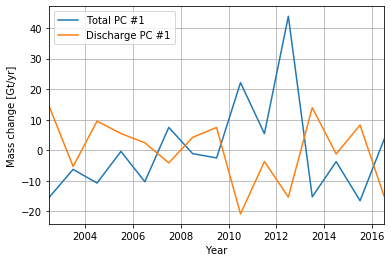

(0.8024883000458517, 0.00031755647674808543)


In [492]:
PCA_num1 = 1
PCA_num2 = 1
PCA_type1 = PCA
PCA_type2 = PCA_SMB
anticoef = -1


plt.plot(xlist, PCA_type1[:,PCA_num1-1])#/np.std(PCA_type1[:,PCA_num1-1]))
plt.plot(xlist, anticoef*PCA_type2[:,PCA_num2-1])#/np.std(PCA_type2[:,PCA_num2-1]))
plt.xlim((2002.5,2016.5))
plt.legend(('Total PC #1', 'Discharge PC #1'))
plt.xlabel('Year')
plt.ylabel('Mass change [Gt/yr]')
plt.grid()
plt.show()
print(pearsonr(PCA_type1[:,PCA_num1-1],PCA_type2[:,PCA_num2-1]))

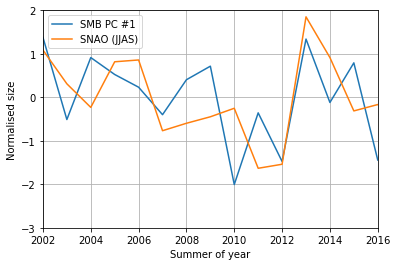

In [493]:
PCA_num = 1
PCA_type = PCA_SMB
int_t = snao_t
ind_d = snao_d
anti_corr = -1

plt.plot(xlist-0.5, -PCA_type[:,PCA_num-1]/np.std(PCA_type[:,PCA_num-1]))
plt.plot(int_t/86400/365.25+2002-0.5,-anti_corr*(ind_d-np.mean(ind_d))/np.std(ind_d))
plt.xlim((2002,2016))
plt.legend(('SMB PC #1','SNAO (JJAS)'))
plt.ylim(-3,2)
plt.xlabel('Summer of year')
plt.ylabel('Normalised size')
#plt.title('PC' + str(PCA_num))
plt.grid()
plt.show()

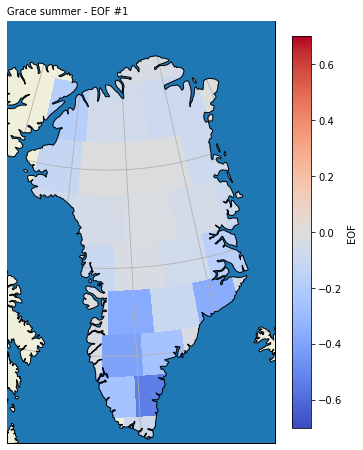

In [494]:
eof_i = 1
XV, YV, eof_fit = rebin_data(np.real(evecs[:,eof_i-1]), lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
#cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -0.7, vmax = 0.7, transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Grace summer - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
plt.show()

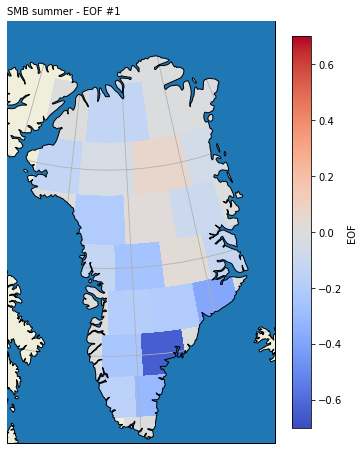

In [495]:
eof_i = 1
XV, YV, eof_fit = rebin_data(np.real(evec_smb[:,eof_i-1]), lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
#cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -0.7, vmax = 0.7, transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "SMB summer - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
plt.show()

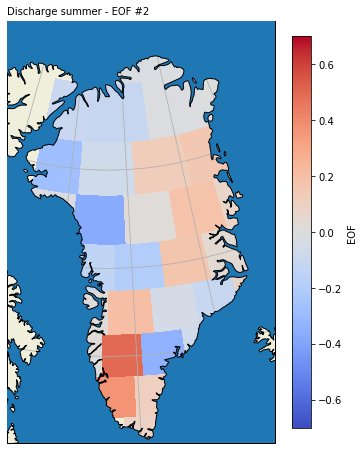

In [496]:
eof_i = 2
XV, YV, eof_fit = rebin_data(np.real(evecs_d[:,eof_i-1]), lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
#cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -0.7, vmax = 0.7, transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Discharge summer - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")

plt.show()